# **기계학습 중간과제: 클러스터링**
**<div style="text-align: right"> 202120990 김도환 </div>**

* **목표:**
    * 전기차 충전소 클러스터링을 통한 전기차 충전소 최적 위치 선정 

분석의 목적은 도시 내 전기차 충전소의 위치와 이용 패턴을 파악하여, 전기차 충전소의 입지 선정


 
* **사용데이터:**
    * 한국환경공단에서 제공하는 전기차 충전소 위치 및 운영정보 데이터
    * 한국환경공단에서 제공하는 환경부 전기차 충전기 충전량 상세정보 데이터


In [1]:
import warnings
warnings.filterwarnings('ignore')

## **1. CSV에서 데이터 불러오기**

In [2]:
import pandas as pd

charge_info_df = pd.read_csv("./data/한국환경공단_전기차 충전소 위치 및 운영정보.csv", low_memory=False)
charge_amount_df = pd.read_csv("./data/한국환경공단_환경부 전기차 충전기 충전량 상세정보.csv", low_memory=False)
print("========== 전기차 충전소 정보 ==========")
print(charge_info_df.info())
print("\n========== 전기차 충전소 충전량 ==========")
print(charge_amount_df.info())

========== 전기차 충전소 정보 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44580 entries, 0 to 44579
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   설치년도     44580 non-null  int64 
 1   시도       44580 non-null  object
 2   군구       44499 non-null  object
 3   주소       44580 non-null  object
 4   충전소명     44580 non-null  object
 5   시설구분(대)  44537 non-null  object
 6   시설구분(소)  44580 non-null  object
 7   기종(대)    44580 non-null  object
 8   기종(소)    44580 non-null  object
 9   운영기관(대)  44580 non-null  object
 10  운영기관(소)  44580 non-null  object
 11  급속충전량    348 non-null    object
 12  충전기타입    44580 non-null  object
 13  이용자제한    44580 non-null  object
 14  충전기ID    44580 non-null  int64 
 15  충전소ID    44580 non-null  object
 16  위도경도     44574 non-null  object
dtypes: int64(2), object(15)
memory usage: 5.8+ MB
None

========== 전기차 충전소 충전량 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0

## **2. 데이터 전처리**
### **2-1. 데이터 병합**

전기차 충전소 정보에 대한 데이터 형식을 확인합니다.

In [3]:
charge_info_df.head(1)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,충전기ID,충전소ID,위도경도
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1,ME174003,"37.5529087,127.1372547"


형태를 확인해보면 위도경도 데이터가 하나의 칼럼에 묶여있는 것을 알 수 있습니다.
해당 칼럼을 위도 칼럼, 경도 칼럼으로 나누어줍니다.

In [4]:
charge_info_df["위도"] = charge_info_df["위도경도"].str.split(",").str[0].astype(float)
charge_info_df["경도"] = charge_info_df["위도경도"].str.split(",").str[1].astype(float)
charge_info_df.head(1)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,충전기ID,충전소ID,위도경도,위도,경도
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1,ME174003,"37.5529087,127.1372547",37.552909,127.137255


이제 충전소ID 칼럼을 기준으로 충전기 충전량 데이터와 충전소 정보 데이터를 합쳐줍니다.

In [5]:
merge_df = pd.merge(charge_info_df, charge_amount_df, how="inner", on="충전소ID")
merge_df.head(1)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),...,2023년 05월 충전횟수,2023년 05월 충전량,2023년 06월 충전횟수,2023년 06월 충전량,2023년 07월 충전횟수,2023년 07월 충전량,2023년 08월 충전횟수,2023년 08월 충전량,2023년 09월 충전횟수,2023년 09월 충전량
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,180,3396.71,181,3549.98,175,3350.6,168,3300.8,136,2719.79


In [6]:
for i in range(len(merge_df)):
    charge_amount = merge_df.filter(regex='.* 충전량$').loc[i].sum()
    charge_count = merge_df.filter(regex='.* 충전횟수$').loc[i].sum()
    merge_df.loc[i, "총충전량"] = charge_amount
    merge_df.loc[i, "총충전횟수"] = charge_count

In [7]:
merge_df.head(1)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),...,2023년 06월 충전횟수,2023년 06월 충전량,2023년 07월 충전횟수,2023년 07월 충전량,2023년 08월 충전횟수,2023년 08월 충전량,2023년 09월 충전횟수,2023년 09월 충전량,총충전량,총충전횟수
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,181,3549.98,175,3350.6,168,3300.8,136,2719.79,33244.11,1733.0


In [8]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   설치년도            2090 non-null   int64  
 1   시도              2090 non-null   object 
 2   군구              2090 non-null   object 
 3   주소              2090 non-null   object 
 4   충전소명            2090 non-null   object 
 5   시설구분(대)         2090 non-null   object 
 6   시설구분(소)         2090 non-null   object 
 7   기종(대)           2090 non-null   object 
 8   기종(소)           2090 non-null   object 
 9   운영기관(대)         2090 non-null   object 
 10  운영기관(소)         2090 non-null   object 
 11  급속충전량           2090 non-null   object 
 12  충전기타입           2090 non-null   object 
 13  이용자제한           2090 non-null   object 
 14  충전기ID_x         2090 non-null   int64  
 15  충전소ID           2090 non-null   object 
 16  위도경도            2090 non-null   object 
 17  위도              2090 non-null   f

### **2-2. 데이터셋에 사용할 특성만 추출**

In [9]:
dataset = merge_df[[
    "급속충전량", 
    "충전기타입", 
    "이용자제한", 
    "시설구분(소)", 
    "운영기관(소)", 
    "위도", 
    "경도", 
    "총충전량",
    "총충전횟수"
]]

### **2-3. 범주형 데이터에 대한 원-핫 인코딩**

In [10]:
ohe_dataset = pd.get_dummies(data=dataset, columns=["급속충전량", "충전기타입", "이용자제한", "시설구분(소)", "운영기관(소)"])
ohe_dataset.head()

,위도,경도,총충전량,총충전횟수,급속충전량_급속(100kW단독),급속충전량_급속(100kW동시),급속충전량_급속(100kW멀티),급속충전량_급속(200kW동시),급속충전량_급속(400kW동시),급속충전량_급속(50kW),...,시설구분(소)_서비스센터,시설구분(소)_숙박시설,시설구분(소)_일반주차장,시설구분(소)_전시관,시설구분(소)_주민센터,시설구분(소)_지자체시설,시설구분(소)_학교,시설구분(소)_홍보관,시설구분(소)_환승주차장,운영기관(소)_환경부(협회)
0,37.552909,127.137255,33244.11,1733.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,37.544812,127.121840,32004.17,1758.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,37.538795,127.133399,19134.38,993.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,37.537263,126.838379,16962.38,761.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,37.528956,126.849089,37188.74,1923.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [13]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
# le = LabelEncoder()

X = ohe_dataset
# y = ohe_dataset["총충전량"]

# '총충전량' 열에 대해 Label Encoding 적용
# X["총충전량"] = le.fit_transform(X["총충전량"])
# y = le.transform(y)

In [14]:
X.columns

Index(['위도', '경도', '총충전량', '총충전횟수', '급속충전량_급속(100kW단독)', '급속충전량_급속(100kW동시)',
       '급속충전량_급속(100kW멀티)', '급속충전량_급속(200kW동시)', '급속충전량_급속(400kW동시)',
       '급속충전량_급속(50kW)', '급속충전량_완속(30kW단독)', '급속충전량_초급속(350kW단독)',
       '충전기타입_DC차데모+AC3상+DC콤보', '충전기타입_DC차데모+DC콤보', '충전기타입_DC콤보',
       '충전기타입_DC콤보(완속)', '이용자제한_이용가능', '이용자제한_이용자제한', '시설구분(소)_경찰서',
       '시설구분(소)_고속도로 휴게소', '시설구분(소)_공공기관', '시설구분(소)_공영주차장', '시설구분(소)_공원',
       '시설구분(소)_공원주차장', '시설구분(소)_공중전화부스', '시설구분(소)_관공서', '시설구분(소)_관광안내소',
       '시설구분(소)_관광지', '시설구분(소)_관람장', '시설구분(소)_금융기관', '시설구분(소)_도서관',
       '시설구분(소)_마트(쇼핑몰)', '시설구분(소)_박물관', '시설구분(소)_백화점', '시설구분(소)_병원',
       '시설구분(소)_복지관', '시설구분(소)_사업장(사옥)', '시설구분(소)_서비스센터', '시설구분(소)_숙박시설',
       '시설구분(소)_일반주차장', '시설구분(소)_전시관', '시설구분(소)_주민센터', '시설구분(소)_지자체시설',
       '시설구분(소)_학교', '시설구분(소)_홍보관', '시설구분(소)_환승주차장', '운영기관(소)_환경부(협회)'],
      dtype='object')

## **K-평균 클러스터링 알고리즘을 사용해 데이터 클러스터링**

In [15]:
# KMeans 클러스터링 알고리즘 임포트
from sklearn.cluster import KMeans

# 클러스터 수와 랜덤 시드 설정
nclusters = 3
seed = 0

# KMeans 모델 생성 및 훈련
km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X)

# 각 데이터 포인트의 클러스터 예측
y_cluster_kmeans = km.predict(X)
y_cluster_kmeans

array([1, 1, 2, ..., 0, 0, 0], dtype=int32)

In [16]:
# sklearn.metrics 모듈 임포트
from sklearn import metrics

# Silhouette Score 계산
score = metrics.silhouette_score(X, y_cluster_kmeans)
score

0.8247699797018119

## **엘보우 방법을 사용해 최적의 클러스터 수 결정**

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

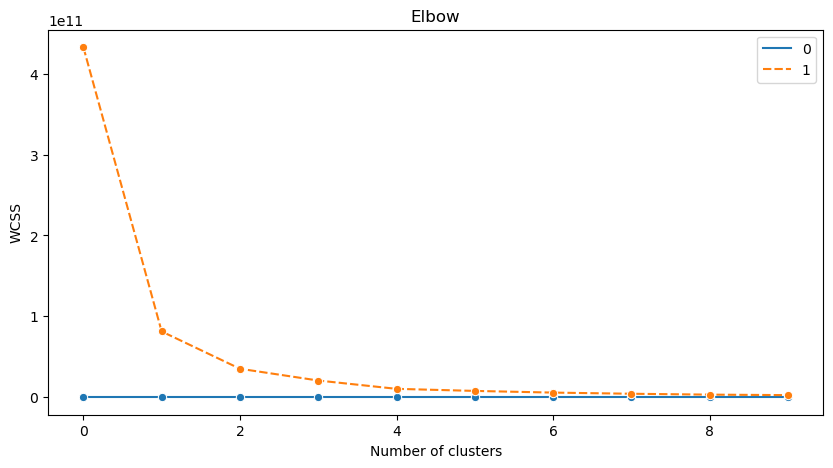

In [20]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(data=(range(1, 11), wcss), marker='o', color='red')
plt.title('Elbow')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## **결정된 k 값으로 클러스터링 수정**

0.8247699797018119


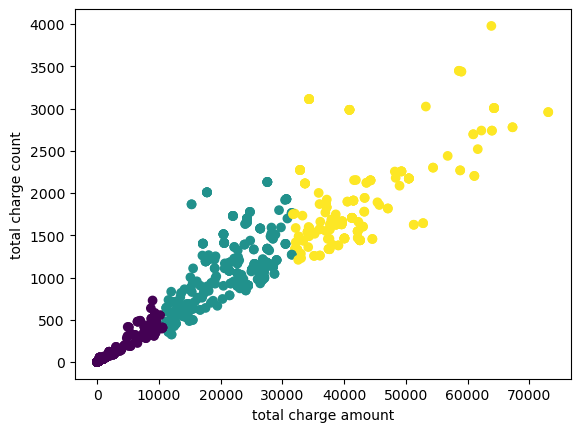

In [28]:
# KMeans 클러스터링 알고리즘 임포트
from sklearn.cluster import KMeans


# KMeans 모델 생성 및 훈련
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# 각 데이터 포인트의 클러스터 레이블 예측
labels = kmeans.predict(X)

# Silhouette Score 계산
score = metrics.silhouette_score(X, labels)
print(score)

# Scatter plot 그리기
plt.scatter(X['총충전량'], X['총충전횟수'], c=labels)

# x축 및 y축 라벨 설정
plt.xlabel("total charge amount")
plt.ylabel("total charge count")

# 그래프 출력
plt.show()

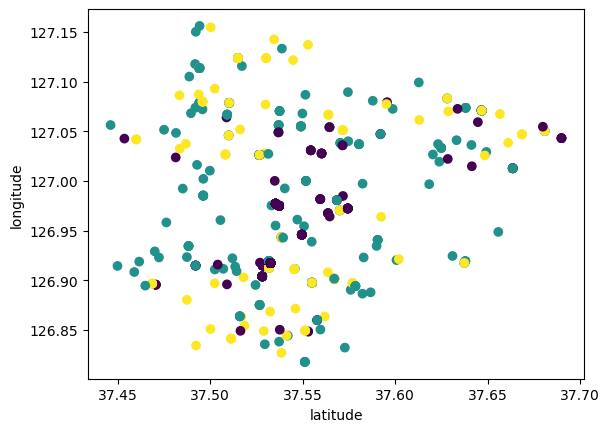

In [25]:
# Scatter plot 그리기
plt.scatter(X['위도'], X['경도'], c=labels)

# x축 및 y축 라벨 설정
plt.xlabel("latitude")
plt.ylabel("longitude")

# 그래프 출력
plt.show()

In [23]:
kmeans.cluster_centers_

array([[ 3.75370452e+01,  1.26973307e+02,  6.25175761e+02,
         3.21766645e+01,  1.77982861e-01,  2.17534608e-02,
         1.31839156e-03,  1.31839156e-02, -4.68375339e-17,
         1.05471325e-02,  7.59393540e-01,  1.58206987e-02,
         1.64798945e-02,  2.63678312e-03,  2.21489782e-01,
         7.59393540e-01,  9.99340804e-01,  6.59195781e-04,
         8.56954515e-03, -5.85469173e-18,  5.47132498e-02,
         1.38431114e-02,  1.73472348e-18, -1.46367293e-18,
        -2.92734587e-18, -4.68375339e-17, -2.92734587e-18,
        -1.46367293e-18,  8.78048780e-01,  2.63678312e-03,
         1.05471325e-02,  1.91166777e-02, -5.85469173e-18,
        -1.04083409e-17,  5.85469173e-18, -1.46367293e-18,
         6.59195781e-04, -1.46367293e-18,  1.31839156e-03,
         0.00000000e+00, -1.46367293e-18,  1.31839156e-03,
         4.61437047e-03,  1.97758734e-03, -5.85469173e-18,
         2.63678312e-03,  1.00000000e+00],
       [ 3.75465180e+01,  1.26995367e+02,  2.11014140e+04,
         1.06

In [ ]:
labels = kmeans.labels_

correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

In [ ]:
# 결과 분석 및 평가
# 클러스터 분석 : 
# 각 클러스터의 중심점을 분석하고 중심점을 바탕으로 각 클러스터의 특성 설명하기
# 클러스터를 시각화해 각 클러스터가 어떻게 구성되어있는지 보여주는 산점도 작성

In [ ]:
# 평가 : 실루엣 점수를 사용해 클러스터링 효과를 평가 / 실루엣 점수가 클러스터링 결과에 대해 어떤 정보를 제공하는지 설명